In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt


2025-05-05 19:44:49.773401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746474289.988642      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746474290.048876      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    rescale=1/255.0,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,  
    brightness_range=[0.8, 1.2],
    vertical_flip=False,
)

val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
)

train_gen = data_gen.flow_from_directory(
    directory="/kaggle/input/brain-tumor-mri-dataset/Training",
    target_size = (224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    color_mode='rgb',
)

test_gen = val_gen.flow_from_directory(
    directory = "/kaggle/input/brain-tumor-mri-dataset/Testing",
    target_size = (224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    color_mode='rgb',
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


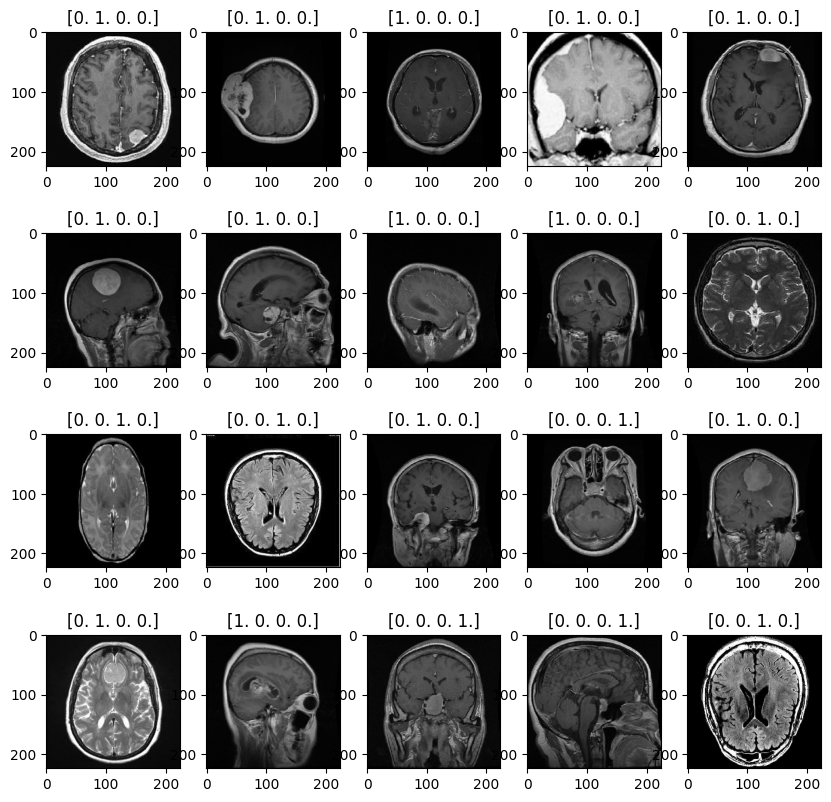

In [3]:
images,labels = next(test_gen)
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(images[i])
    plt.title(str(labels[i]))
plt.show()

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D, Dense, Reshape, Dropout, 
                                     BatchNormalization, GlobalAveragePooling1D, LayerNormalization, Add)
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras.layers import MultiHeadAttention

input_layer = Input(shape=(224, 224, 3))
base_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=input_layer)

# Freeze all layers except the last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)

x_1 = Reshape((1, x.shape[-1]))(x)

embed_dim = 1024
x_1 = Dense(embed_dim)(x_1)
x_residual = x_1

x_1 = LayerNormalization(epsilon=1e-6)(x_1)
x_att = MultiHeadAttention(num_heads=8, key_dim=embed_dim)(x_1, x_1)
x_att = LayerNormalization(epsilon=1e-6)(x_att)
x_att = Add()([x_att, x_residual])

x = GlobalAveragePooling1D()(x_att)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32, activation="relu")(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-5, clipnorm=1.0),
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')],
)

early_stopping = EarlyStopping(patience=8, monitor='val_loss', mode='min', restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model.fit(
    train_gen,
    epochs=10,
    batch_size=32,
    validation_data=test_gen,
    callbacks=[early_stopping, lr_scheduler]
)


I0000 00:00:1746474306.438881      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746474343.251877      74 service.cc:148] XLA service 0x7884f8825e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746474343.252720      74 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00

  2/179 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.2656 - loss: 1.7337 - precision: 0.2201 - recall: 0.1094   

I0000 00:00:1746474362.887391      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 191s 781ms/step - accuracy: 0.5752 - loss: 1.0599 - precision: 0.6738 - recall: 0.4424 - val_accuracy: 0.7986 - val_loss: 0.5470 - val_precision: 0.8297 - val_recall: 0.7582 - learning_rate: 1.0000e-05
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 413ms/step - accuracy: 0.7748 - loss: 0.6232 - precision: 0.8441 - recall: 0.6961 - val_accuracy: 0.8139 - val_loss: 0.4893 - val_precision: 0.8564 - val_recall: 0.7780 - learning_rate: 1.0000e-05
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 411ms/step - accuracy: 0.8161 - loss: 0.5427 - precision: 0.8801 - recall: 0.7384 - val_accuracy: 0.8246 - val_loss: 0.4549 - val_precision: 0.8794 - val_recall: 0.7788 - learning_rate: 1.0000e-05
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 410ms/step - accuracy: 0.8339 - loss: 0.5013 - precision: 0.8859 - recall: 0.7627 - val_accuracy: 0.8459 - val_loss: 0.4179 - val_precision: 0.8895 - val_recall: 0.7986 - learning_rate: 1.0000e-05
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 41

updates from previous method

ReduceLROnPlateau
* It automatically reduces the learning rate when the model's performance stops improving on a monitored metric (like validation loss). This helps fine-tune the model gradually when it gets close to convergence.
  
Freezing and unfreezing the layers
* When using a pre-trained model (e.g., DenseNet121 trained on ImageNet), early layers capture general patterns (edges, textures) useful for all images.
So we freeze these layers to avoid retraining and save time.
* The last layers learn task-specific features, which might not match my dataset
* By unfreezing the last 20 layers, we allow the model to adapt to your task while retaining general knowledge from pretraining.
* this is called fine tuning.

* Used MultiHeadAttention from tensorflow